In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

# Model

In [9]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        size=32
        
        self.fc=nn.Sequential(
            nn.Linear(100,4*4*512),
            nn.ReLU()
        )
        self.layer=nn.Sequential(
            nn.ConvTranspose2d(512,size*8,3,2,1),
            nn.BatchNorm2d(size*8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(size*8,size*4,4,2,1),
            nn.BatchNorm2d(size*4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(size*4,1,4,2,1),
            nn.Tanh()        
        )
    
    def forward(self,x):
        out=self.fc(x)
        out=out.view(out.size(0),512,4,4)
        out=self.layer(out)        
        return out
        

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        size=32
        self.layer1=nn.Sequential(
            nn.Conv2d(1,size*8,3,2,1),
            nn.BatchNorm2d(size*8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(size*8,size*4,3,2,1),
            nn.BatchNorm2d(size*4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(size*4,size*2,3,2,1),
            nn.BatchNorm2d(size*2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(size*2,size,3,2,1),
            nn.BatchNorm2d(size),
            nn.LeakyReLU(0.2)
        )
        self.layer2=nn.Sequential(
            nn.Linear(128,1,bias=True),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        out=self.layer1(x)
        out=out.view(out.size(0),-1)
        out=self.layer2(out)
        
        return out
    
g=Generator()

print(g.forward(torch.rand(1,100)).shape)

d=Discriminator()

print(d.forward(torch.rand(1,1,32,32)).shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1])


# Train

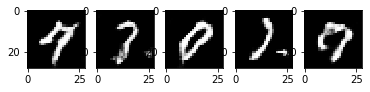

Epoch = 0 Gen = 1.8946057094344453 Dis = 0.8120194532469646


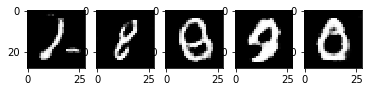

Epoch = 1 Gen = 1.8317032543930418 Dis = 0.7335070556542004


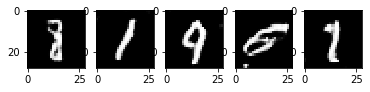

Epoch = 2 Gen = 2.0992545807587186 Dis = 0.6196139800999718


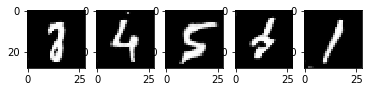

Epoch = 3 Gen = 2.5848157039837543 Dis = 0.4777411205856912


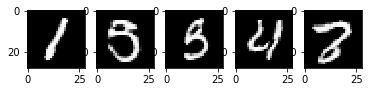

Epoch = 4 Gen = 2.8283616470963335 Dis = 0.42087566055484543


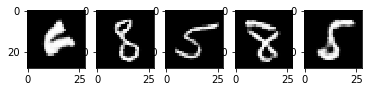

Epoch = 5 Gen = 3.095621952858529 Dis = 0.37147931612805646


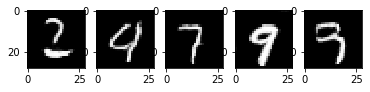

Epoch = 6 Gen = 3.231655856046373 Dis = 0.3320067201131411


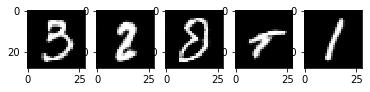

Epoch = 7 Gen = 3.142308970587626 Dis = 0.3783383470362247


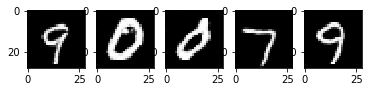

Epoch = 8 Gen = 3.322037894612373 Dis = 0.3252520263909912


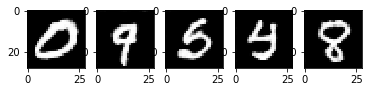

Epoch = 9 Gen = 3.6480106434880146 Dis = 0.2625237646461057


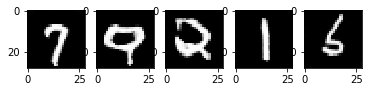

Epoch = 10 Gen = 3.453286903610489 Dis = 0.30892583164674386


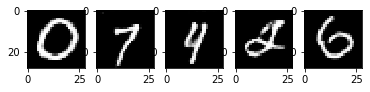

Epoch = 11 Gen = 3.6083089698082222 Dis = 0.28542997934984593


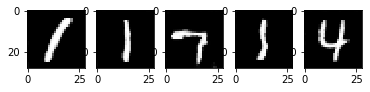

Epoch = 12 Gen = 3.7085237492130063 Dis = 0.27750847799214984


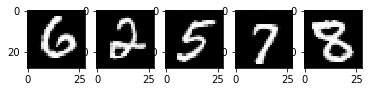

Epoch = 13 Gen = 3.9657054594608705 Dis = 0.2360135684760887


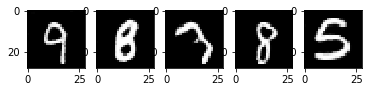

Epoch = 14 Gen = 3.627377938272666 Dis = 0.28416452434525563


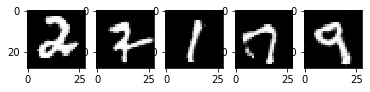

Epoch = 15 Gen = 3.958644864020317 Dis = 0.23266329530622565


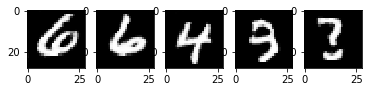

Epoch = 16 Gen = 3.923843715181038 Dis = 0.24694256416446508


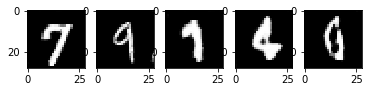

Epoch = 17 Gen = 3.987172198940569 Dis = 0.24802407878401406


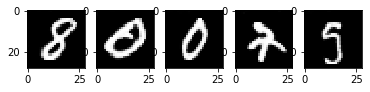

Epoch = 18 Gen = 4.123269786795648 Dis = 0.22217806235183157


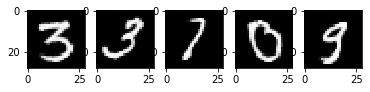

Epoch = 19 Gen = 4.025927102483157 Dis = 0.23179265017038397


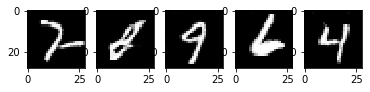

Epoch = 20 Gen = 3.9186863695650596 Dis = 0.24730906282702506


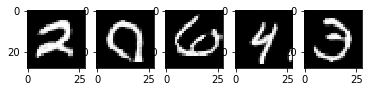

Epoch = 21 Gen = 4.397232882861199 Dis = 0.18496310121979492


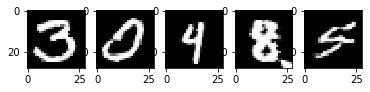

Epoch = 22 Gen = 4.041125184060064 Dis = 0.22053415191420384


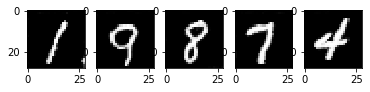

Epoch = 23 Gen = 4.254346690230024 Dis = 0.20396309553869943


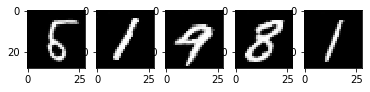

Epoch = 24 Gen = 3.9327683920688083 Dis = 0.25126567341115225


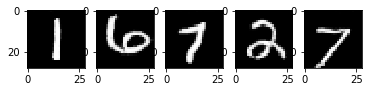

Epoch = 25 Gen = 4.166831446680496 Dis = 0.21937644881591487


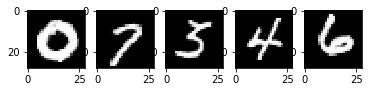

Epoch = 26 Gen = 4.281391932031334 Dis = 0.20865768458702164


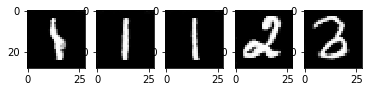

Epoch = 27 Gen = 4.670082459174621 Dis = 0.14298879621259528


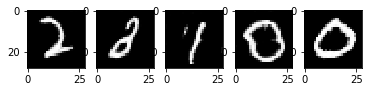

Epoch = 28 Gen = 4.31301123363081 Dis = 0.23429147097399272


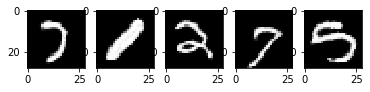

Epoch = 29 Gen = 4.534332570093654 Dis = 0.16640938681027573


In [25]:

device='cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])])

train_data=dsets.MNIST(root='MNIST_data/',train=True,transform=transform,download=True)
train_loader=DataLoader(dataset=train_data,shuffle=True,batch_size=64)

NetG=Generator().to(device)
NetD=Discriminator().to(device)

#NetG.load_state_dict(torch.load('param/DCGAN_G.pth'))
#NetD.load_state_dict(torch.load('param/DCGAN_D.pth'))

criterion=nn.BCELoss()

optim_G=optim.Adam(NetG.parameters(),lr=0.001,betas=(0.5,0.999))
optim_D=optim.Adam(NetD.parameters(),lr=0.001,betas=(0.5,0.999))

for epoch in range(30):
    avg_G,avg_D=0.0,0.0
    for X,Y in train_loader:
        X,Y=X.to(device),Y.to(device)
        
        real_label=torch.ones(X.size(0),1).to(device)
        fake_label=torch.zeros(X.size(0),1).to(device)        
        rand=torch.randn(X.size(0),100).to(device)
        
        ### Discriminator Loss ###        
        real_output=NetD(X)
        fake_output=NetD(NetG(rand))
        
        cost_D_Real=criterion(real_output,real_label)
        cost_D_Fake=criterion(fake_output,fake_label)
                              
        cost_D=cost_D_Real+cost_D_Fake
        
        optim_D.zero_grad()
        cost_D.backward()        
        optim_D.step()        
        
        ### Generator Loss ###
        rand=torch.randn(X.size(0),100).to(device)
        Gen_img=NetG(rand)      
        
        cost_G=criterion(NetD(Gen_img),real_label)
        
        optim_G.zero_grad()
        cost_G.backward()        
        optim_G.step()
        
        avg_D+=cost_D.item()
        avg_G+=cost_G.item()
    else:
        fig,(axes) = plt.subplots(1,5)
        
        for i,ax in enumerate(axes):
            ax.imshow(Gen_img[i].detach().view(28,28).cpu().numpy(),cmap='gray')
        plt.show()
    
    avg_D/=len(train_loader)
    avg_G/=len(train_loader)
    
    torch.save(NetG.state_dict(),'param/DCGAN_G.pth')
    torch.save(NetD.state_dict(),'param/DCGAN_D.pth')
    print('Epoch =',epoch,'Gen =',avg_G,'Dis =',avg_D)